# Entity Resolution project @ Wavestone
## Entity Matching

> *Datasets information from [here](https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/index.html)*

> **Tristan PERROT**


## Import libraries


In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import os

import torch

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:2


In [15]:
while 'model' not in os.listdir():
    os.chdir('..')

In [16]:
MODEL_NAME = ''
DATA_NAME = 'amazon-google'
COMPUTER = 'gpu4.enst.fr:' + str(device)[-1:]
DATA_DIR = os.path.join('data', DATA_NAME)

## Pre-processing

In [17]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
from sentence_transformers import CrossEncoder, InputExample, SentencesDataset
from sentence_transformers.cross_encoder.evaluation import \
    CEBinaryClassificationEvaluator
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader

from model.utils import load_data

/home/infres/tperrot-21/venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [18]:
table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(DATA_DIR, order_cols=True)

In [19]:
X1_train, X2_train = [table_a_serialized[i[0]] for i in X_train_ids], [table_b_serialized[i[1]] for i in X_train_ids]
X1_valid, X2_valid = [table_a_serialized[i[0]] for i in X_valid_ids], [table_b_serialized[i[1]] for i in X_valid_ids]
X1_test, X2_test = [table_a_serialized[i[0]] for i in X_test_ids], [table_b_serialized[i[1]] for i in X_test_ids]

In [20]:
# Display the first 5 samples of the training set
for i in range(5):
    print(f'Sample {i}:')
    print(f'Entity1: {X1_train[i]}')
    print(f'Entity2: {X2_train[i]}')
    print(f'Label: {y_train[i]}')
    print()

Sample 0:
Entity1: microsoft powerpoint 2004 (mac) powerpoint 2004 offers you the powerful advanced new tools needed for fantastic presentations. whether it's for business academic or personal needs you'll design dynamic and visual presentations that stand out and get noticed. microsoft 229.99
Entity2: microsoft office outlook 2007 key features: manages time and info works with sharepoint enhanced search one-click functionality create internet calendars enhanced security ...  109.95
Label: 0

Sample 1:
Entity1: peachtree by sage premium accounting 2007 - accountants' edition peachtree premium accounting 2007 accountants' edition is the powerful multi-user ready accounting solution accountants need to service their peachtree clients more effectively and efficiently. create open modify and save client files from any member of the peachtree 2007 line plus handle complex tasks such as company consolidation compensation management and comprehensive budgeting. converts quicken and quickbooks

In [21]:
train_datasets = [InputExample(texts=[X1_train[i], X2_train[i]], label=y_train[i]) for i in range(len(X_train_ids))]
valid_datasets = [InputExample(texts=[X1_valid[i], X2_valid[i]], label=y_valid[i]) for i in range(len(X_valid_ids))]
test_datasets = [InputExample(texts=[X1_test[i], X2_test[i]], label=y_test[i]) for i in range(len(X_test_ids))]
train_loader = DataLoader(train_datasets, shuffle=True, batch_size=16, num_workers=0)
valid_loader = DataLoader(valid_datasets, shuffle=False, batch_size=16, num_workers=0)
test_examples = DataLoader(test_datasets, shuffle=False, batch_size=16, num_workers=0)

valid_evaluation_set = [(e1, e2) for e1, e2 in zip(X1_valid, X2_valid)]

In [22]:
EPOCHS = 3
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 300
CLASSIFIER_DROPOUT = None
threshold = 0.5

loss_fct = BCEWithLogitsLoss()

def callback(score, epoch, steps):
    print(f'Epoch {epoch} - Score {score} - Steps {steps}')

In [23]:
final_table_exports = ""
results = {}

In [24]:
def show_results():
    global results
    roc_curve_fig, roc_curve_ax = plt.subplots(figsize=(10, 10))
    acc_threshold_fig, acc_threshold_ax = plt.subplots(figsize=(10, 10))
    prec_recall_threshold_fig, prec_recall_threshold_ax = plt.subplots(figsize=(10, 10))
    f1_threshold_fig, f1_threshold_ax = plt.subplots(figsize=(10, 10))

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, (model_name, (logits, train_time)) in enumerate(results.items()):
        y_pred = logits > threshold
        y_true = y_test
        print(f'Model: {model_name}')
        print(classification_report(y_true, y_pred))
        print(f'AUC: {roc_auc_score(y_true, logits)}')
        print(f'Train time: {train_time}')
        print()
        fpr, tpr, _ = roc_curve(y_true, logits)
        roc_curve_ax.plot(fpr, tpr, label=model_name)

        # Confusion matrix
        plt.figure()
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')

        thresholds = np.linspace(0, 1, 100)
        accuracies = []
        precions = []
        recalls = []
        f1_scores = []
        for th in thresholds:
            y_pred = logits > th
            accuracies.append(np.mean(y_pred == y_true))
            precions.append(np.sum(y_pred * y_true) / np.sum(y_pred) if np.sum(y_pred) != 0 else 1)
            recalls.append(np.sum(y_pred * y_true) / np.sum(y_true))
            f1_scores.append(2 * precions[-1] * recalls[-1] / (precions[-1] + recalls[-1]) if precions[-1] + recalls[-1] != 0 else 0)
        acc_threshold_ax.plot(thresholds, accuracies, label=model_name)
        prec_recall_threshold_ax.plot(thresholds, precions, label=model_name + " precision", color=colors[i])
        prec_recall_threshold_ax.plot(thresholds, recalls, label=model_name + " recall", color=colors[i], linestyle='--')
        f1_threshold_ax.plot(thresholds, f1_scores, label=model_name)


    
    roc_curve_ax.plot([0, 1], [0, 1], 'k--')
    roc_curve_ax.set_xlabel('False Positive Rate')
    roc_curve_ax.set_ylabel('True Positive Rate')
    roc_curve_ax.set_title('ROC curve')
    roc_curve_ax.legend()

    acc_threshold_ax.set_xlabel('Threshold')
    acc_threshold_ax.set_ylabel('Accuracy')
    acc_threshold_ax.set_title('Accuracy vs Threshold')
    acc_threshold_ax.legend()

    prec_recall_threshold_ax.set_xlabel('Threshold')
    prec_recall_threshold_ax.set_ylabel('Precision/Recall')
    prec_recall_threshold_ax.set_title('Precision/Recall vs Threshold')
    prec_recall_threshold_ax.axvline(x=threshold, color='k', linestyle='--', label='Threshold = 0.5')
    prec_recall_threshold_ax.legend()

    f1_threshold_ax.set_xlabel('Threshold')
    f1_threshold_ax.set_ylabel('F1 Score')
    f1_threshold_ax.set_title('F1 Score vs Threshold')
    f1_threshold_ax.axvline(x=threshold, color='k', linestyle='--', label='Threshold = 0.5')
    f1_threshold_ax.legend()

    plt.show()

### MS Marco MiniLM l-12

- Architecture: MiniLM-L-12
- Parameters: ~33 million
- Layers: 12 Transformer layers
- Hidden Size: 384
- Attention Heads: 12
- Link to the model: [here](https://huggingface.co/cross-encoder/ms-marco-TinyBERT-L-2-v2)
- MS MARCO Passage Retrieval is a large dataset with real user queries from Bing search engine with annotated relevant text passages.

In [25]:
MODEL_NAME = 'cross-encoder/ms-marco-MiniLM-L-12-v2'
OUTPUT_PATH = os.path.join('results', DATA_NAME, MODEL_NAME)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [26]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT, default_activation_function=nn.Sigmoid())

In [27]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            output_path=OUTPUT_PATH,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 0 - Score 0.7486003147043591 - Steps -1


Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1 - Score 0.806445358685567 - Steps -1


Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2 - Score 0.8136648056887769 - Steps -1


In [28]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
results[MODEL_NAME] = (logits, train_time)

In [29]:
# Exemple of prediction
print(f'Prediction: {y_pred[0]}')
print(f'Label: {y_test[0]}')
print(f'Sample 1: {X1_test[0]}')
print(f'Sample 2: {X2_test[0]}')

Prediction: False
Label: 0
Sample 1: adobe photoshop cs3 extended ideal for film video and multimedia professionals and graphic and web designers using 3d and motion as well as professionals in engineering and science adobe photoshop cs3 extended software delivers everything in photoshop cs3 and more. render and incorporate 3d images into your 2d composites. stop time with easy editing of motion graphics on video layers. and probe your images with measurement analysis and visualization tools. the professional standard now comes in two versions& 151;photoshop cs3 and photoshop cs3 extended with additional features and enhancements for specialized image professionals. the clone stamp and healing brush tools now feature an overlay preview of the source areas. the loupe tool in adobe bridge cs3 lets you easily zoom into the fine detail of any image. zoomify export allows you to efficiently display even the highest resolution imagery over low bandwidth web connections. edit 3d and motion-ba

In [30]:
e1, e2 = X1_test[np.nonzero(y_test)[0][0]], X2_test[np.nonzero(y_test)[0][0]]
print('Entity 1:', e1)
print('Entity 2:', e2)
print(f'Label: {y_test[np.nonzero(y_test)[0][0]]}')
print(f'Prediction: {y_pred[np.nonzero(y_test)[0][0]]}')

Entity 1: calculation skills v1 add & sub - basic - core learning this four volume series builds fundamental calculation competence with four core arithmetic operations. two volumes provide calculation practice with addition and subtraction at a basic and advanced level; the other two volumes provide calculation practice with multiplication and division at a basic and advanced level. volume 1 features helpful calculation information: how to add addition table how to subtract subtraction table take away from 10 or 9 table money and decimals change from $1.00 table the program provides three timed drills basic addition drill basic subtraction drill making change from $1.00 drillsystem requirements: windows 98/me/2000/xp pentium ii 400 mhz + 96 mb ram + 25 mb hard disk space cd-rom drive vga display 16-bit color with 800x600 resolutionformat: win 98 me 2000 xp sos aggregation company 0.0
Entity 2: sos aggregation company calculation skills v1 add & sub - basic - core learning this four vo

### STS RoBERTa-base

- Architecture: RoBERTa-base
- Parameters: ~125 million
- Layers: 12 Transformer layers
- Hidden Size: 768
- Attention Heads: 12
- Link to the model: [here](https://huggingface.co/cross-encoder/stsb-roberta-base)
- Train to predict the similarity between two sentences

In [31]:
MODEL_NAME = 'cross-encoder/stsb-roberta-base'
OUTPUT_PATH = os.path.join('results', DATA_NAME, MODEL_NAME)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [32]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT)

/home/infres/tperrot-21/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [33]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            output_path=OUTPUT_PATH,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 0 - Score 0.8049689775170841 - Steps -1


Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1 - Score 0.8808900102506788 - Steps -1


Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2 - Score 0.8894650483514145 - Steps -1


In [34]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
results[MODEL_NAME] = (logits, train_time)

### STS DistilRoBERTa-base

- Architecture: DistilRoBERTa-base
- Parameters: ~82 million
- Layers: 6 Transformer layers
- Hidden Size: 768
- Attention Heads: 12
- Link to the model: [here](https://huggingface.co/cross-encoder/stsb-distilroberta-base)
- Train to predict the similarity between two sentences

In [35]:
MODEL_NAME = 'cross-encoder/stsb-distilroberta-base'
OUTPUT_PATH = os.path.join('results', DATA_NAME, MODEL_NAME)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [36]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT)

/home/infres/tperrot-21/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [37]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            output_path=OUTPUT_PATH,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 0 - Score 0.7851419673982637 - Steps -1


Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1 - Score 0.8483823602010707 - Steps -1


Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2 - Score 0.8545643991995725 - Steps -1


In [38]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
results[MODEL_NAME] = (logits, train_time)

Model: cross-encoder/ms-marco-MiniLM-L-12-v2
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       708
           1       0.81      0.83      0.82       128

    accuracy                           0.94       836
   macro avg       0.89      0.90      0.89       836
weighted avg       0.94      0.94      0.94       836

AUC: 0.9658258298022598
Train time: 145.86792469024658

Model: cross-encoder/stsb-roberta-base
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       708
           1       0.85      0.90      0.87       128

    accuracy                           0.96       836
   macro avg       0.92      0.94      0.93       836
weighted avg       0.96      0.96      0.96       836

AUC: 0.9871446857344633
Train time: 404.79488468170166

Model: cross-encoder/stsb-distilroberta-base
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       

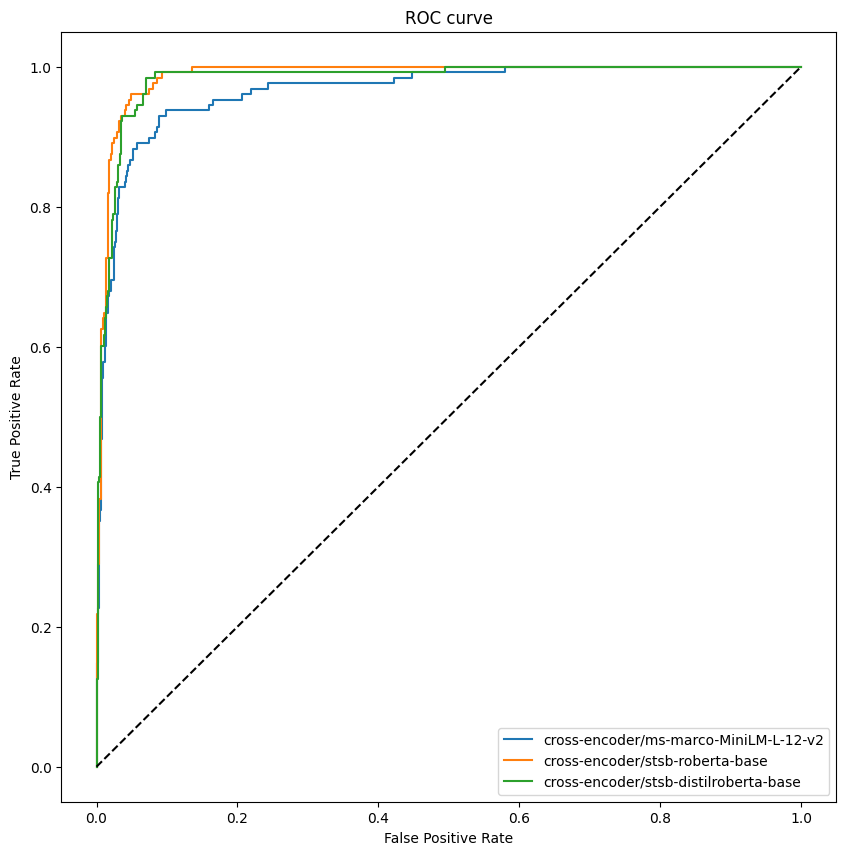

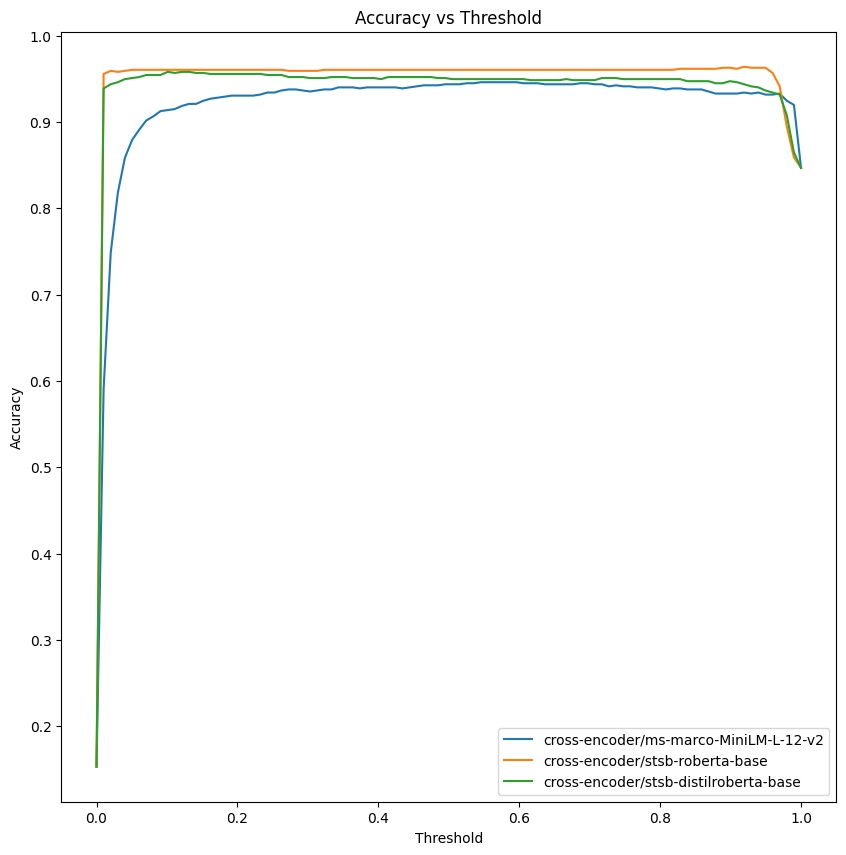

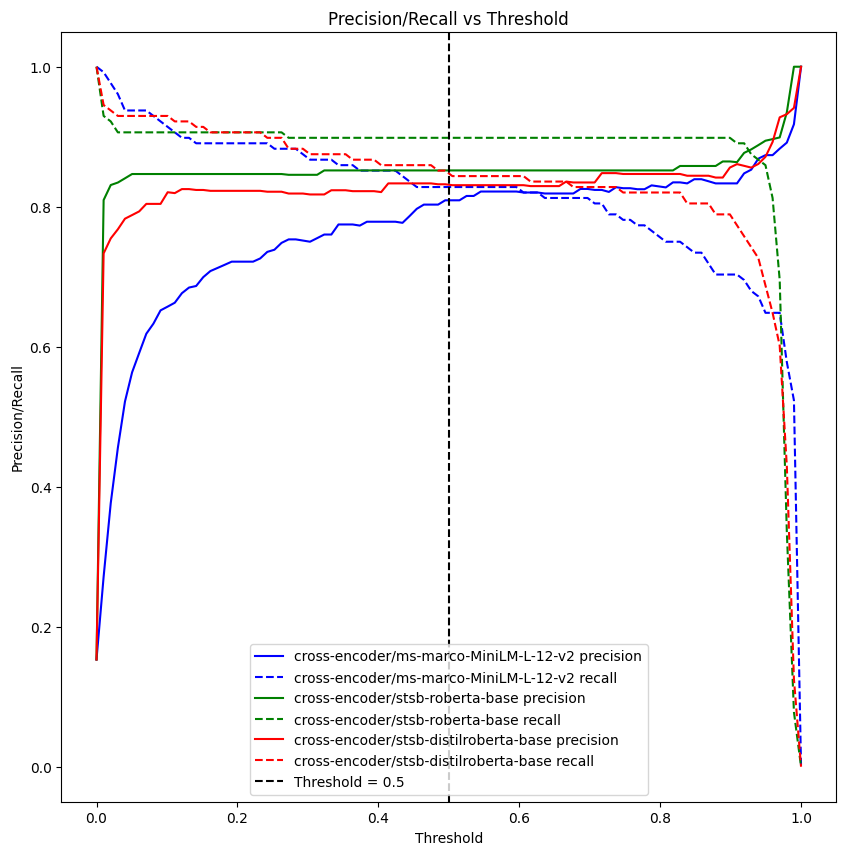

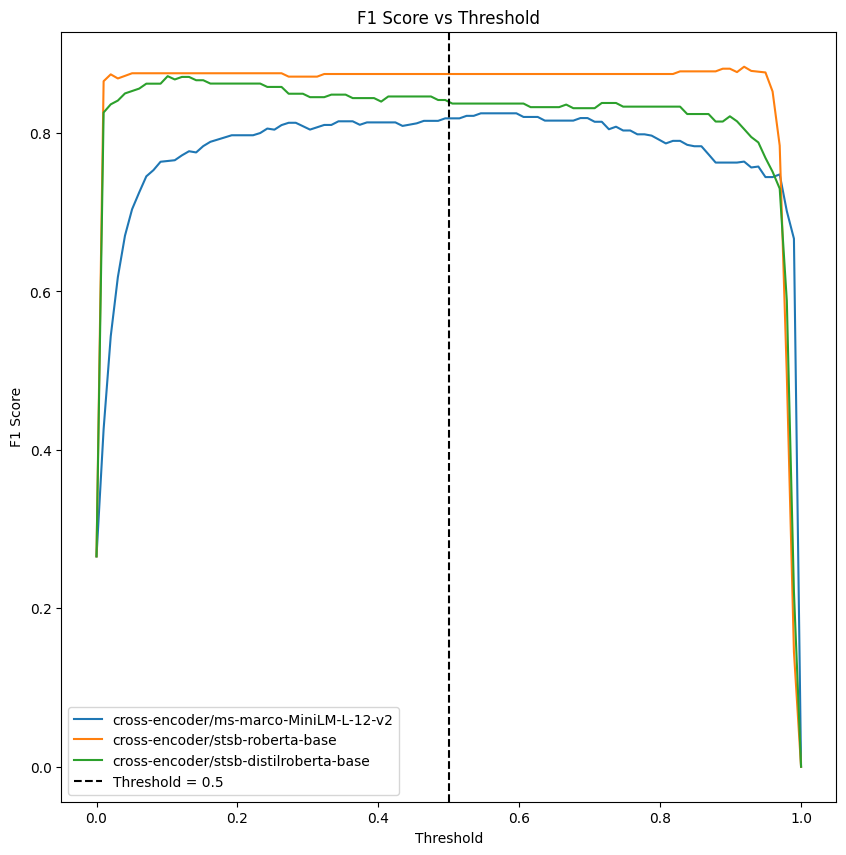

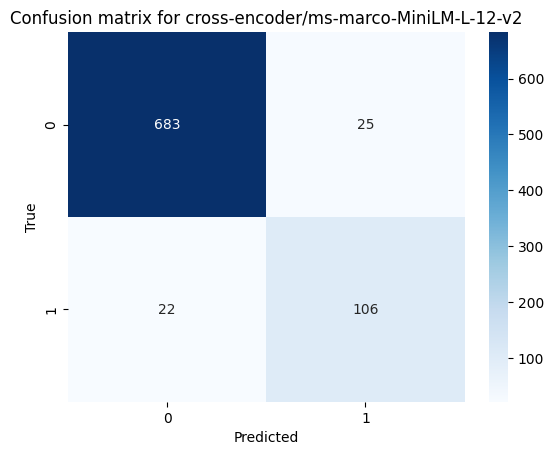

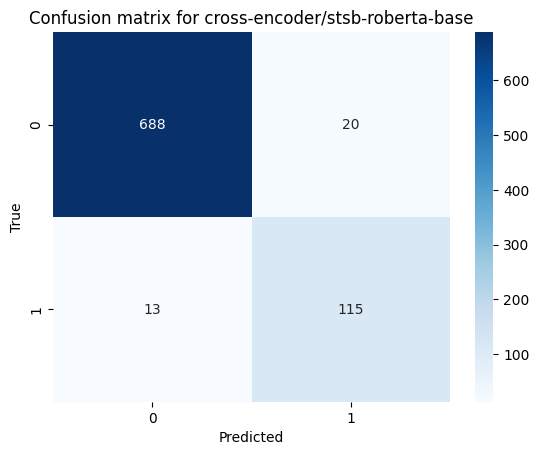

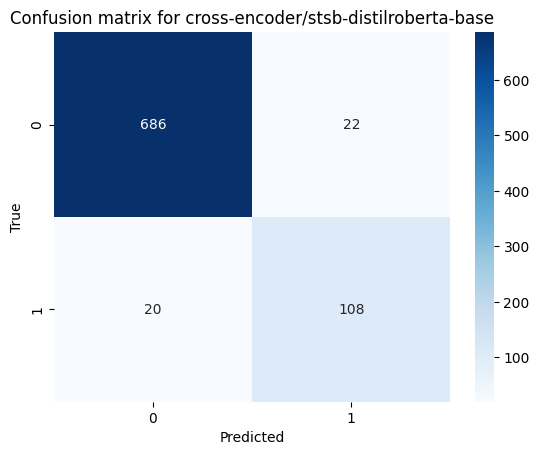

In [39]:
show_results()